In [12]:
library(tidyverse)
library(ncdf4)
library(viridis)
library(fields)

In [19]:
nc <- nc_open("data/Zinser_SizeDist_logtransform-25-7.nc")
PAR   <- ncvar_get(nc,'PAR')
w_obs <- ncvar_get(nc,'w_obs')
m     <- ncvar_get(nc,'m')
delta_v_inv <- ncvar_get(nc,'delta_v_inv')
v_min       <- ncvar_get(nc,'v_min')
time  <- ncvar_get(nc,'time')
time <- as.POSIXct(time*60, origin="2009-05-01")
delta_v <- 1/delta_v_inv
v       <- v_min*2^(0:24*delta_v) 

In [20]:
df <- read.csv("data/Zinser_Figure2A.csv")
abundance <- rowMeans(df[,c(3,2)]) # mean of culture A and B
clean <- smooth.spline(time, abundance, df=15) # smooth abundance data using spline


df2 <- read.csv("data/Zinser_Figure3.csv")


- ### Equation division rate (assuming exponential growth)
$$
DR = ln(\frac{N_1/N_0}t)

In [21]:
dr <- diff(log(clean$y))/diff(clean$x/3600) # calculate hourly division rate
dr[which(dr < 0)] <- 0

[1] "Division rate =  0.65 / day"


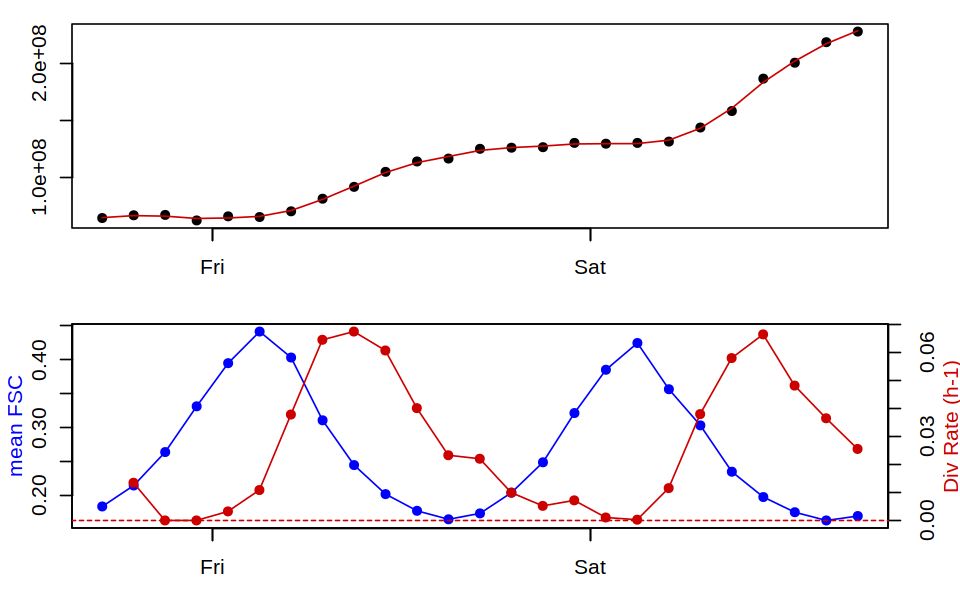

In [22]:
options(repr.plot.width = 8, repr.plot.height = 5)

par(mfrow=c(2,1), mar=c(3,3,1,3))
plot(time, abundance, pch=NA)
#polygon(x=rep(c(1200,1800,2640,3240),each=2), y=rep(c(1,10^9,10^9,1),2), border=NA, col='lightgrey')
points(time, abundance, pch=16)
lines(clean,col="red3" )
plot(time, df[,c(4)], pch=NA, xlab=NA, ylab=NA)
#polygon(x=rep(c(1200,1800,2640,3240),each=2), y=rep(c(-1,1,1,-1),2), border=NA, col='lightgrey')
lines(time, df[,c(4)], col='blue1', type="o", pch=16)
par(new=T)
plot(x=time[-1]-50,y=dr, type='o', pch=16, xaxt='n', yaxt='n', col="red3", xlab=NA, ylab=NA, xlim=range(time))
axis(4) 
mtext("Div Rate (h-1)", 4,2, col="red3")
mtext("mean FSC", 2,2, col="blue1")
abline(h=0, lty=2,col="red3")
print(paste("Division rate = ",round(24*mean(dr),3), "/ day"))


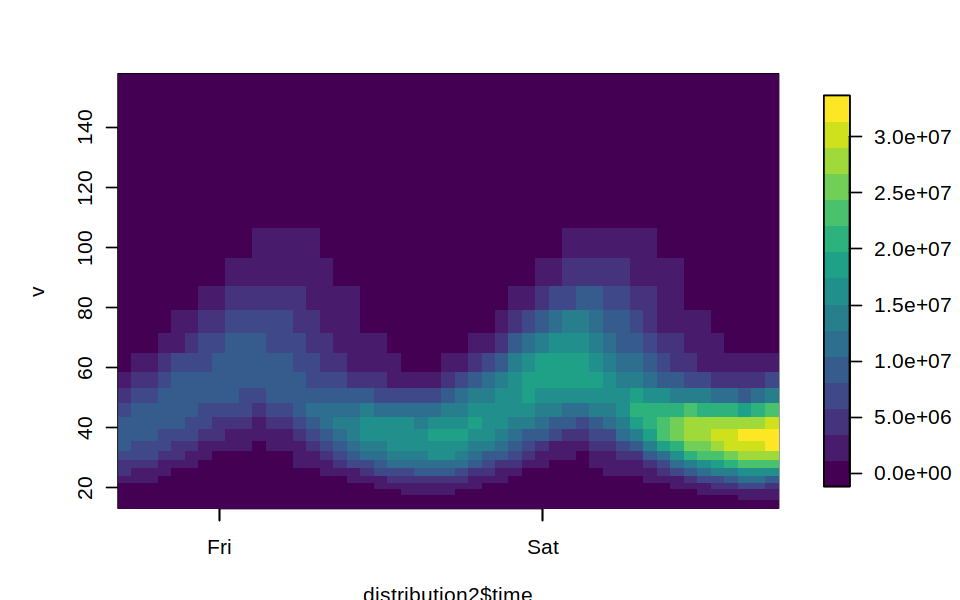

In [24]:
n <- ncol(w_obs)
w_obs2 <- round(w_obs * abundance)

distribution <- as.data.frame(w_obs2)
distribution$time <- time
distribution <- distribution[,c(n+1,1:n)] # reorganize dataframe to be compatible with ssPopModel
colnames(distribution) <- c("time", v)


resol.i <- 60 # in minutes
# Extrapolate dat based on "resol"
time2 <- seq(min(time), max(time), by=60*resol.i)
distribution2 <- NULL
for(i in 2:ncol(distribution)){
     dist.h <- approx(distribution[,1], distribution[,i], xout=time2)
     distribution2 <- cbind(distribution2, dist.h$y)
    }
distribution2 <- data.frame(distribution2)
colnames(distribution2) <- v
#write.csv(DF, "data/FSC_Array5_calibrated_1hr.csv", quote=F, row.names=F)
distribution2$time <- as.POSIXct(time2, origin="1970-01-01")
distribution2 <- distribution2[,c(n+1,1:n)] # reorganize dataframe to be compatible with ssPopModel

options(repr.plot.width = 8, repr.plot.height = 5)
image.plot(x=distribution2$time,y=v,z=as.matrix(distribution2[,-c(1)]), col=viridis(15))

In [25]:
## PAR data
# resolution
resol <- 10 # in minutes

# select PAR data covering the range of the size distribution
par <- data.frame(time=time, par=PAR)
par <- subset(par, time  >= min(distribution2$time) & time  < max(distribution2$time))

# Change temporal resolution 
E <- approx(par$time, par$par, xout=seq(min(par$time), max(par$time), by=60*resol))

# smooth spline
ep <- smooth.spline(E, all.knots=TRUE)
Edata <- ep$y
Edata[Edata < 0] <- 0

##plot
# options(repr.plot.width = 8, repr.plot.height = 4)
# plot(par$time,par$par, type='p', xlab=NA, ylab="Light")
# points(ep$x,Edata, col=4, lwd=3)

In [27]:
source("scripts/functions_model.R")

output <- determine_opt_para(distribution2,Edata,resol)

[1] "Optimizing gmax, dmax, b and E_star"
Iteration: 10 bestvalit: 90394.643670 bestmemit:    0.149270    0.240833    0.316907    0.280272
Iteration: 20 bestvalit: 89299.075271 bestmemit:    0.473369    0.249294    0.287180    0.825459
Iteration: 30 bestvalit: 88938.949741 bestmemit:    0.236986    0.303254    0.317270    0.432746
Iteration: 40 bestvalit: 88893.290460 bestmemit:    0.321671    0.241484    0.295265    0.592573
Iteration: 50 bestvalit: 88841.061090 bestmemit:    0.206001    0.264247    0.302959    0.378070
Iteration: 60 bestvalit: 88840.118101 bestmemit:    0.206001    0.264247    0.302369    0.378070
Iteration: 70 bestvalit: 88840.118101 bestmemit:    0.206001    0.264247    0.302369    0.378070
Iteration: 80 bestvalit: 88839.737356 bestmemit:    0.400192    0.264247    0.302369    0.731681
Iteration: 90 bestvalit: 88839.737336 bestmemit:    0.366816    0.270070    0.304417    0.669492
Iteration: 100 bestvalit: 88838.740485 bestmemit:    0.490351    0.267220    0.303260

In [28]:
params <- output$parameters
        gmax <- as.numeric(params[1]) 
        dmax <- as.numeric(params[2]) 
        b <- as.numeric(params[3]) 
        E_star <- as.numeric(params[4])

resnorm <- as.numeric(params[5])

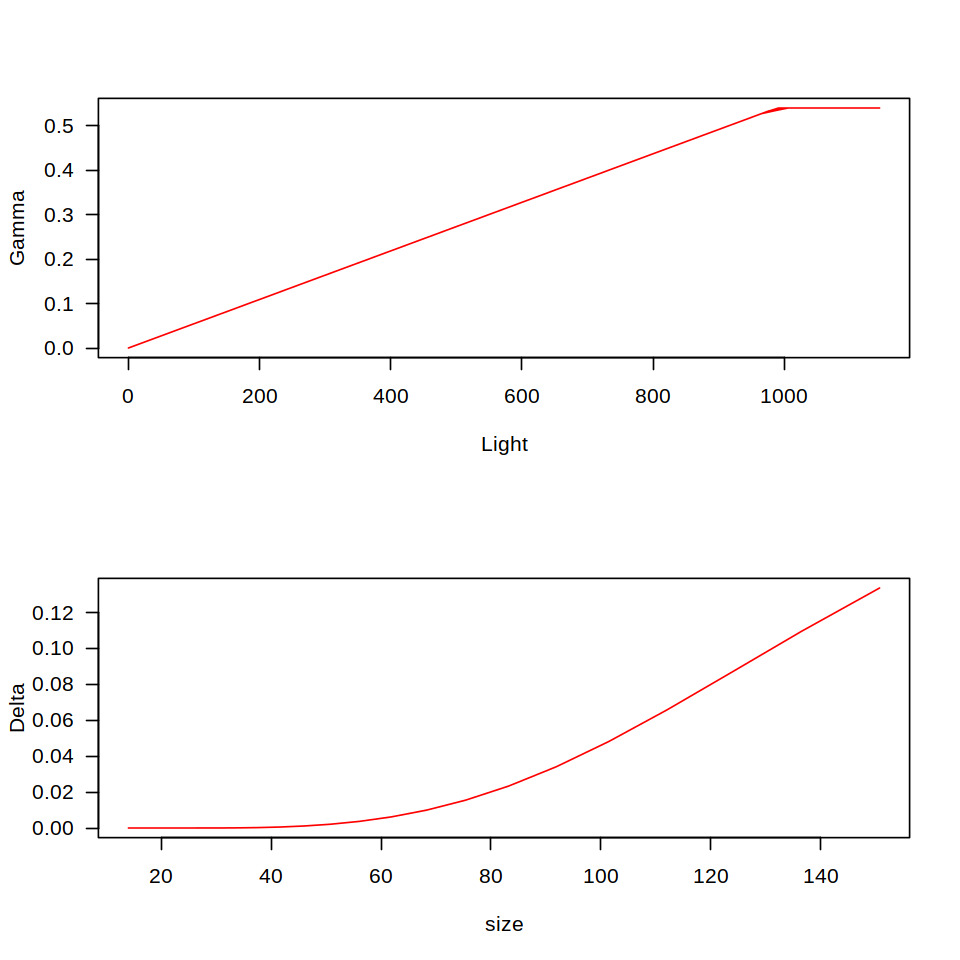

In [29]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(2,1))
plot(Edata*5, gamma_t(Edata*5, gmax, E_star), type='l', col='red', xlab="Light", ylab=paste("Gamma"), las=1)
plot(v, delta(v, dmax, b), type='l', col='red', xlab="size", ylab=paste("Delta"), las=1)    

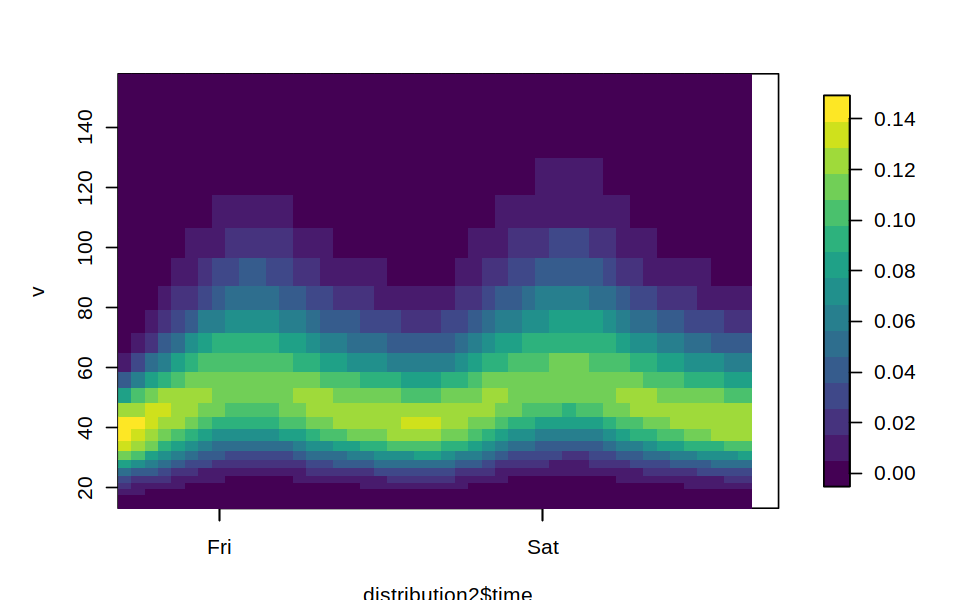

In [30]:
### plot size distribution
PSD <- output$PSD
Nproj <- as.matrix(PSD[,-c(1)])

### plot frequency distribution
s2 <- round(apply(Nproj, 1, function(x) sum(x,na.rm=T)))
Vproj <- as.matrix(Nproj/s2)

options(repr.plot.width = 8, repr.plot.height = 5)
image.plot(x=distribution2$time,y=v,z=as.matrix(Vproj), col=viridis(15))

[1] 14.39121


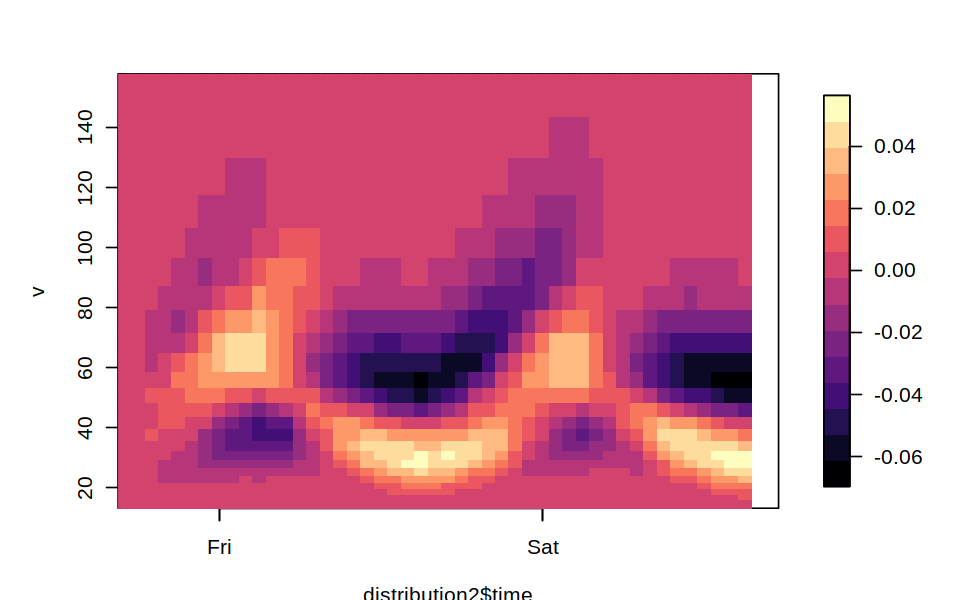

In [31]:
### plot difference Observed - Projected
s <- round(apply(distribution2[,-c(1)], 1, function(x) sum(x,na.rm=T)))                   
z <- as.matrix(distribution2[,-c(1)]/s) - Vproj

print(sum(abs(z), na.rm=T))                 
                 
options(repr.plot.width = 8, repr.plot.height = 5)
image.plot(x=distribution2$time,y=v,z=z, col=viridis(15, option="A"))

[1] "daily growth rate= 0.73"


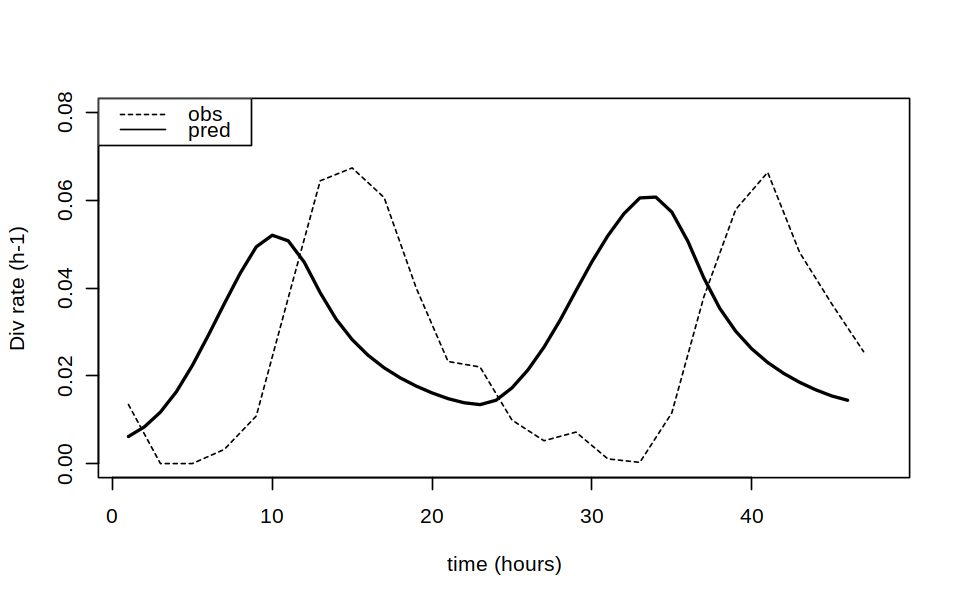

In [32]:
###############################
## Division rate calculation ##
###############################
mu_N <- diff(log(rowSums(PSD[,-c(1)], na.rm=T))) / as.numeric(diff(PSD$time))
d.mu_N <- 24*mean(mu_N[-c(47:48)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N,2)))

#plot
options(repr.plot.width = 8, repr.plot.height = 5)
plot(mu_N,type='l', ylim=c(0,0.08), xlab='time (hours)', ylab="Div rate (h-1)", lwd=2)
lines(seq(1,48,2), y=dr, lty=2)
legend("topleft",c("obs","pred"), lty=c(2,1))

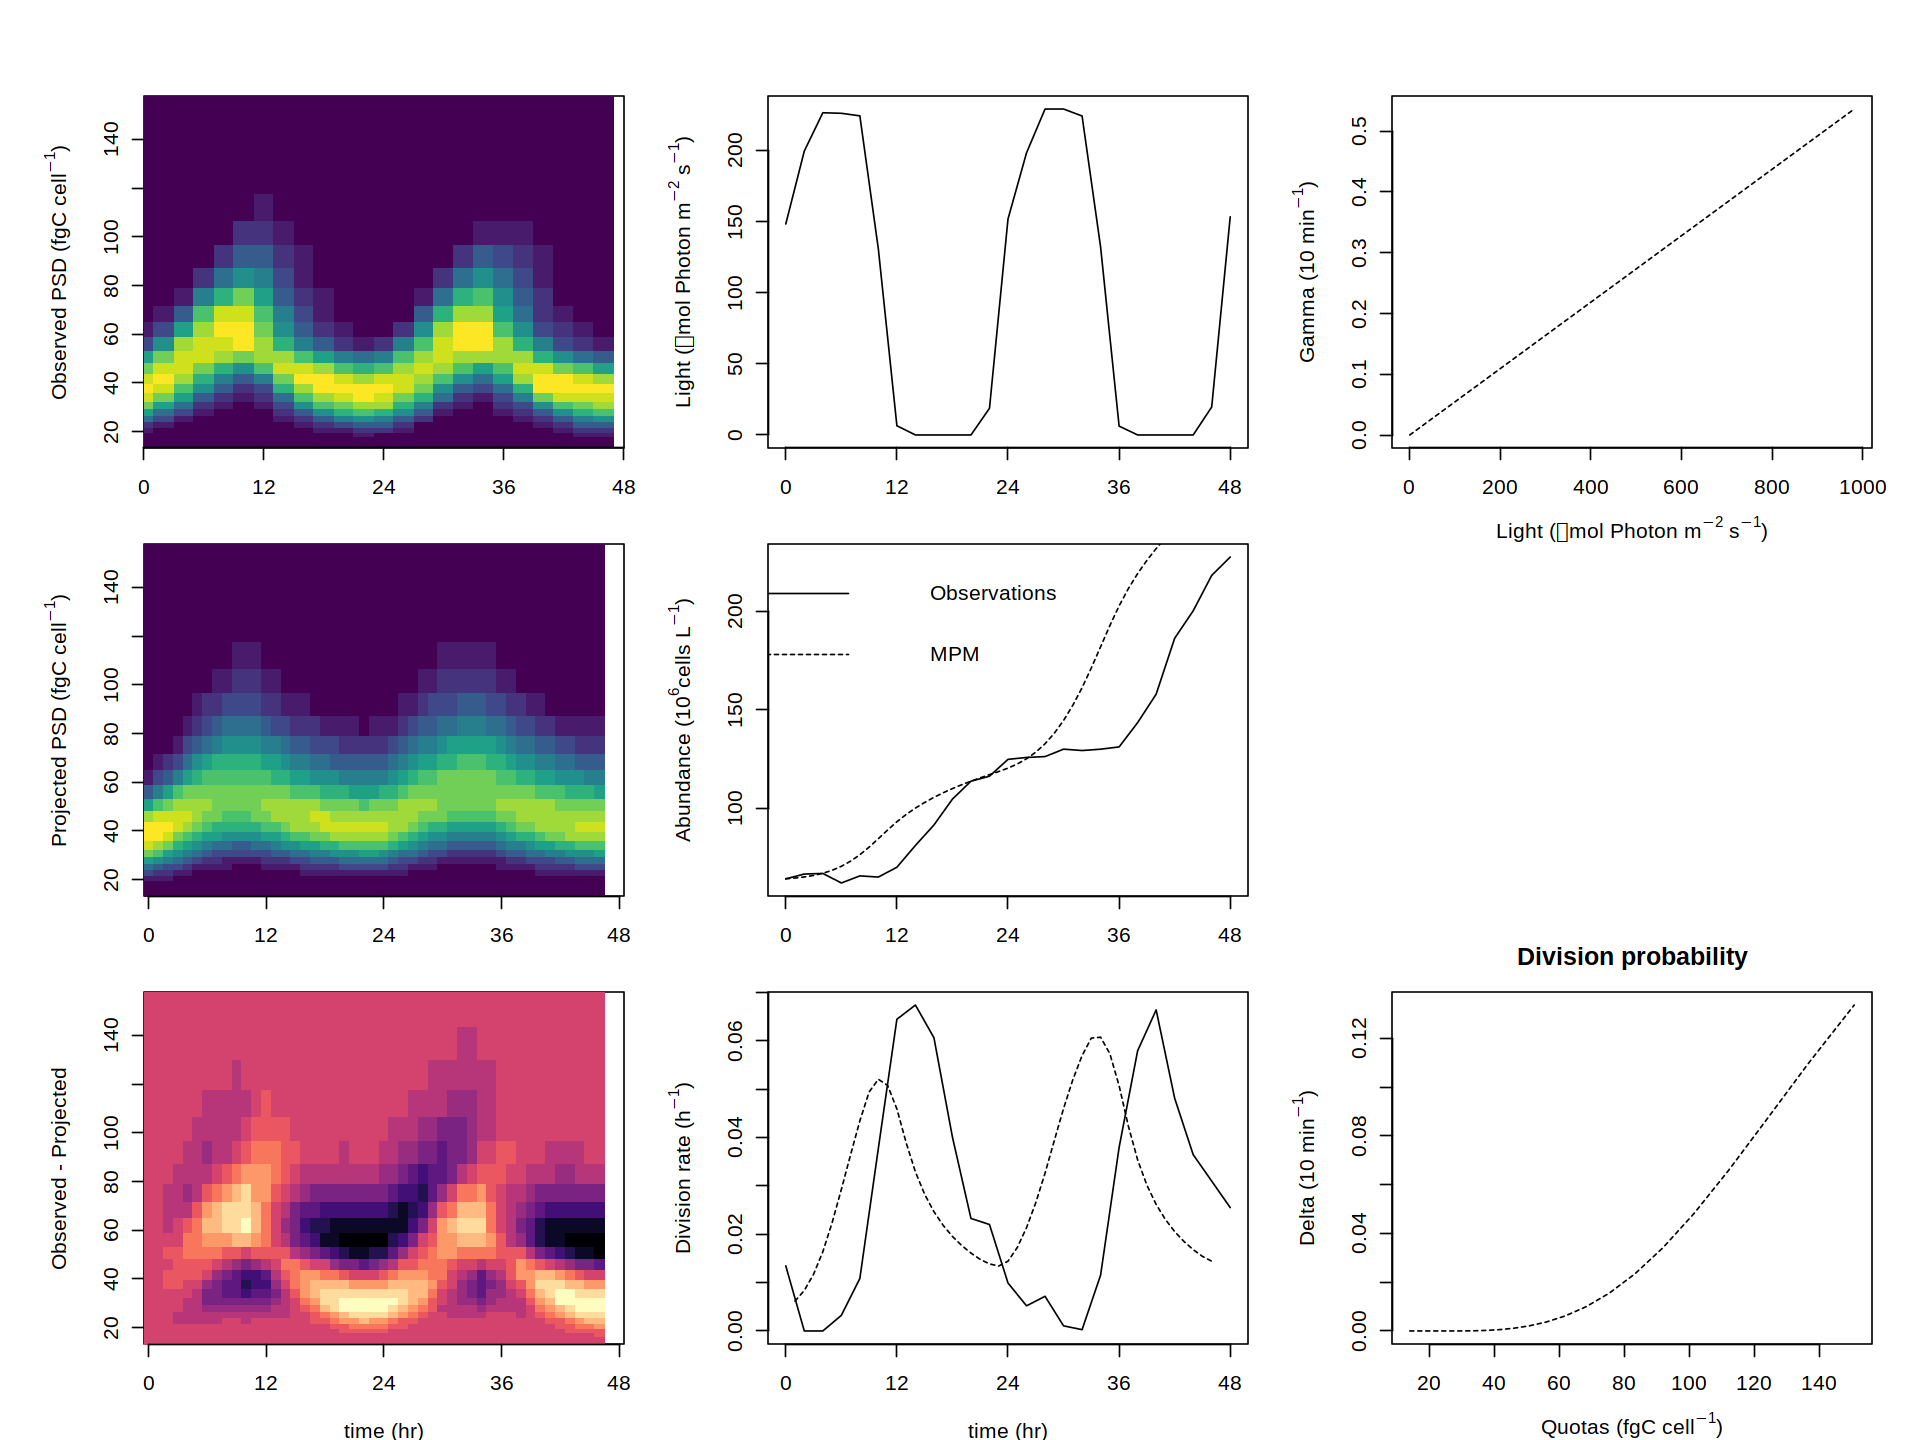

In [33]:
## Comparison Obs vs Model
#colorRampPalette(c("red3", "white","lightblue1"))(15)
r <- range(as.POSIXct(distribution2$time, origin="1970-01-01"))
options(repr.plot.width = 16, repr.plot.height = 12)
layout(matrix(c(1:6,7,0,8), 3, 3, byrow = F))

par(mar=c(1,5,3,1), oma=c(3,1,1,1), lwd=1, cex=1)
image(x=time[-25],y=v, w_obs[-25,],col=viridis(15), ylab=expression('Observed PSD (fgC cell'^-1*')'), xaxt="n", xlim=range(time))
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
image(x=distribution2$time,y=v,Vproj,col=viridis(15),ylab=expression('Projected PSD (fgC cell'^-1*')'), xaxt="n")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
index <- cut(unlist(list(z)),15)
image(x=distribution2$time,y=v,z,col=viridis(15, option="A"),ylab=expression('Observed - Projected'), xaxt="n")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time (hr)", 1, 3)

plot(time,PAR,type='l',xaxt='n', ylab=expression('Light ('*mu*'mol Photon m'^-2*' s'^-1*')'))
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
plot(time, abundance/10^6, type='l', xaxt="n", ylab=expression('Abundance (10'^6*'cells L'^-1*')'), xlim=range(time))
lines(distribution2$time, rowSums(Nproj)/10^6, lty=2)
legend(r[1]-70000, y=240, legend=c("Observations","MPM"), lty=c(1,2), bty="n")
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
plot(x=time[-24],y=dr, type='l', xaxt='n',xlim=range(time), ylab=expression('Division rate (h'^-1*')'))
lines(x=distribution2$time[-c(1)],y=mu_N, lty=2)
axis.POSIXct(1, at = seq(r[1], r[2], by="12 hour"), labels=c(0,12,24,36,48))
mtext("time (hr)", 1, 3)

plot(seq(1,1000,20), gamma_t(seq(1,1000,20), gmax, E_star), type='l', lty=2, ylab=expression('Gamma (10 min'^-1*')'))#, main="Growth probability")
mtext(expression('Light ('*mu*'mol Photon m'^-2*' s'^-1*')'), 1, 3)
plot(v, delta(v, dmax, b), type='l', lty=2, xlab="size", ylab=expression('Delta (10 min'^-1*')'), , main="Division probability") 
mtext(expression('Quotas (fgC cell'^-1*')'), 1,3)

[1] "Avg Quota 46.7 fg cell-1"
[1] "resp/growth = 0.33"


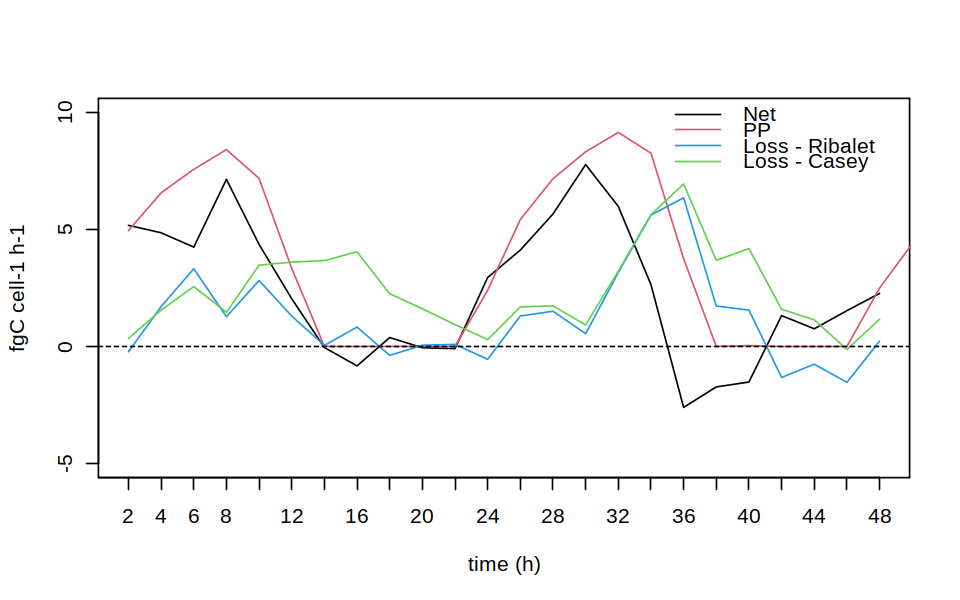

In [37]:
###########################################
## Growth & Respiration rate calculation ##
###########################################
# correction <- 0.74 # correction to get quoats at 48 fg cell-1
# c <- correction * 261 * v^0.861 # Menden-Deuer 
# conversion <- 1.2; quotas <-  conversion *  4/3 * pi * (s/2)^3 # assuming FALS proxy of diameter
# quotas <-  10 +  4/3 * pi * (s/2)^3 # assuming FALS proxy of diameter
quotas <-  v

#1 hr data interpolation, for compatibility with 1-hr model output
pp <- df2[,3]
pp[which(pp < 0)] <- 0
count <- clean$y

#  Calculate total biomass
sm <- 0.25 ## smoothing parameter
biom1 <- diag(quotas) %*%  t(as.matrix(distribution[,-c(1)]))
biom <- smooth.spline(colSums(biom1), spar=sm)$y
obs.quotas <- biom / count
print(paste("Avg Quota", round(mean(obs.quotas),1), "fg cell-1"))

## Option 1: Casey matlab code
pred.biom1 <- (obs.quotas[-25] + pp[-25]) * (count[-1] - diff(count))  + 0.5*(obs.quotas[-25] + pp[-25])*diff(count)
pred.quotas <- pred.biom1 / count[-1] 
resp1 <- -(pred.quotas-obs.quotas[-1])

## Option 2: BiomT1 = BiomT0 + ([PP + Loss] * countT0)
net <- diff(biom) / count[-25] # net
resp <- net - pp[-25] # resp + exudation
#resp[which(resp > 0)] <- 0

print(paste("resp/growth =", round(mean(-resp, na.rm=T)/mean(pp, na.rm=T),2)))

options(repr.plot.width = 8, repr.plot.height = 5)
plot(net, ylim=c(-5,10), type='l', ylab="fgC cell-1 h-1", xlab="time (h)", xaxt="n") 
axis(1, at=seq(0,24,by=1), labels=seq(0,48,2))
lines(pp,col=2) 
lines(-resp, col=4) # Ribalet
lines(-resp1, col=3) # Casey
abline(h=0, lty=2)
legend("topright", c("Net","PP","Loss - Ribalet", "Loss - Casey"), col=c(1,2,4,3), lwd=1, bty="n")

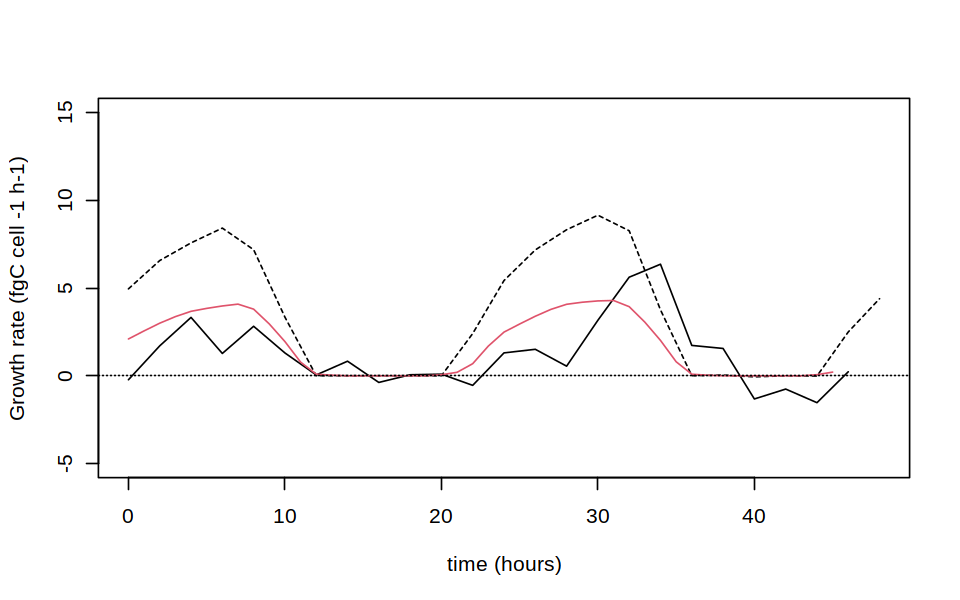

In [38]:
###########################
### Proj Net growth rate ###
############################
biom <-  diag(quotas) %*%  t(Nproj)
gr <- diff(colSums(biom, na.rm=T)) / (rowSums(Nproj, na.rm=T)[-1]) 

options(repr.plot.width = 8, repr.plot.height = 5)
plot(seq(0,48,2), df2[,3], ylim=c(-5,15),type="l", lty=2, xlab='time (hours)', ylab="Growth rate (fgC cell -1 h-1)")
lines(seq(0,47,2), -resp)
lines(seq(0,47,1), gr, col=2); abline(h=0, lty=3)